In [1]:
import pandas as pd
import numpy as np

import re
import nltk
import html
import string

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score, ConfusionMatrixDisplay
import torch

from transformers import AutoTokenizer, AutoModel
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
plt.style.use('ggplot')

In [2]:
%matplotlib inline

In [4]:
df_train_dl = pd.read_csv(r'C:\Users\t\drugLibTrain_raw.tsv', sep="\t", index_col=0).dropna()
df_test_dl = pd.read_csv(r'C:\Users\t\drugLibTest_raw.tsv', sep="\t", index_col=0).dropna()

In [5]:
def classes_def(x):
    if x <= 4:
        return 0
    elif x >= 7:
        return 2
    else:
        return 1


In [6]:
df_train_dl['full_rev'] = df_train_dl['benefitsReview'] + df_train_dl['sideEffectsReview'] + df_train_dl['commentsReview']
df_test_dl['full_rev'] = df_test_dl['benefitsReview'] + df_test_dl['sideEffectsReview'] + df_test_dl['commentsReview']

In [7]:

X_rating_train = df_train_dl['commentsReview']
X_rating_test = df_test_dl['commentsReview']

y_rating_train = df_train_dl['rating']
y_rating_test = df_test_dl['rating']


y_rating_train=y_rating_train.apply(lambda x:classes_def(x))
y_rating_test=y_rating_test.apply(lambda x:classes_def(x))

X_benefitsReview_train = df_train_dl.benefitsReview
X_benefitsReview_test = df_test_dl.benefitsReview

y_benefitsReview_train = df_train_dl.effectiveness
y_benefitsReview_test = df_test_dl.effectiveness


X_sideEffects_train = df_train_dl.sideEffectsReview
X_sideEffects_test = df_test_dl.sideEffectsReview

y_sideEffects_train = df_train_dl.sideEffects
y_sideEffects_test = df_test_dl.sideEffects


X_full_rew_train = df_train_dl.full_rev
X_full_rew_test = df_test_dl.full_rev


In [8]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

"unzip" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [9]:
PUNCT_TO_REMOVE = string.punctuation
STOPWORDS = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}


def remove_punctuation(text):
    
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))


def remove_stopwords(text):

    return " ".join([word for word in str(text).split() if word not in STOPWORDS])


def lemmatize_words(text):

    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])


def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)


def remove_urls(text):

    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_html(text):

    text = html.unescape(text)
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)


In [10]:
def prep(text):
    text = text.str.lower()
    text = text.apply(remove_emoji)
    text = text.apply(remove_urls)
    text = text.apply(remove_html)

    text = text.apply(lambda t: remove_punctuation(t))
    text = text.apply(lambda t: lemmatize_words(t))
    text = text.apply(lambda t: remove_stopwords(t))

    return text


In [11]:
X_rating_train = prep(X_rating_train)
X_rating_test = prep(X_rating_test)

X_benefitsReview_train = prep(X_benefitsReview_train)
X_benefitsReview_test = prep(X_benefitsReview_test) 

X_sideEffects_train = prep(X_sideEffects_train)
X_sideEffects_test = prep(X_sideEffects_test)



In [12]:
tokenizer = AutoTokenizer.from_pretrained("medicalai/ClinicalBERT")
model = AutoModel.from_pretrained("medicalai/ClinicalBERT")

tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

c:\Users\t\AppData\Local\Programs\Python\Python39\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\t\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/542M [00:00<?, ?B/s]

In [13]:
gpu_num = 0
device = torch.device(f'cuda:{gpu_num}' if torch.cuda.is_available() else 'cpu')


def get_emdeddings(model, train, test, tokenizer, max_length=512):
    
        
        tokenized_texts = train.apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=max_length, truncation=True)).values
        max_len = max(len(text) for text in tokenized_texts)
        padded_texts = torch.tensor([text + [0] * (max_len - len(text)) for text in tokenized_texts])
        attention_mask = torch.where(padded_texts > 0, 1, 0)
        
        model.to(device)
        batch_size = 16
        
        features = []
        with torch.no_grad():
            for i in tqdm(range(0, len(padded_texts), batch_size)):
                texts_batch = padded_texts[i : i + batch_size].to(device)
                mask_batch = attention_mask[i : i + batch_size].to(device)
                output = model(texts_batch, mask_batch)
                batch_features = output.last_hidden_state[:, 0, :].cpu().numpy()
                features.append(batch_features)

        features = np.concatenate(features, axis=0)

        

        tokenized_texts_test = test.apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=max_length, truncation=True)).values
        max_len_test = max(len(text) for text in tokenized_texts_test)
        padded_texts_test = torch.tensor([text + [0] * (max_len_test - len(text)) for text in tokenized_texts_test])
        attention_mask_test = torch.where(padded_texts_test > 0, 1, 0)

        features_test = []
        with torch.no_grad():
            for i in tqdm(range(0, len(padded_texts_test), batch_size)):
                texts_batch_test = padded_texts_test[i : i + batch_size].to(device)
                mask_batch_test = attention_mask_test[i : i + batch_size].to(device)
                output_test = model(texts_batch_test, mask_batch_test)
                batch_features_test = output_test.last_hidden_state[:, 0, :].cpu().numpy()
                features_test.append(batch_features_test)

        features_test = np.concatenate(features_test, axis=0)

        return features, features_test

In [14]:
from sklearn.decomposition import NMF

def get_nmf(train, test,n_components=20 ):
    nmf = NMF(n_components=n_components, random_state=42)
    vectorizer = CountVectorizer(max_df=0.8, min_df=10, stop_words='english')
    train = vectorizer.fit_transform(train)
    test = vectorizer.transform(test)
    
    nmf.fit(train)
    nmf_features_train = nmf.transform(train)
    nmf_features_test = nmf.transform(test)
    
    return nmf_features_train, nmf_features_test

In [15]:
side_train_bert, side_test_bert = get_emdeddings(model,X_sideEffects_train, X_sideEffects_test, tokenizer)

100%|██████████| 63/63 [24:21<00:00, 23.20s/it]


In [16]:
side_train_nmf, side_test_nmf = get_nmf(X_sideEffects_train, X_sideEffects_test)

In [17]:
train_lda_bert = np.concatenate((side_train_bert, side_train_nmf), axis=1)
test_lda_bert = np.concatenate((side_test_bert, side_test_nmf), axis=1)

In [18]:
y_sideEffects_train = y_sideEffects_train.replace({'Extremely Severe Side Effects': 'Severe', 'Severe Side Effects': 'Severe',
        'Mild Side Effects': 'Moderate', 'Moderate Side Effects': 'Moderate' })

y_sideEffects_test = y_sideEffects_test.replace({'Extremely Severe Side Effects': 'Severe', 'Severe Side Effects': 'Severe',
        'Mild Side Effects': 'Moderate', 'Moderate Side Effects': 'Moderate' })

## bert  Side eff

In [23]:
model = CatBoostClassifier(verbose=1000, iterations=1000, random_state=20)

model.fit(side_train_bert, y_sideEffects_train)
preds = model.predict(side_test_bert)

print(classification_report(y_sideEffects_test, preds))

Learning rate set to 0.083695
0:	learn: 1.0526807	total: 2.76s	remaining: 45m 54s
999:	learn: 0.1089457	total: 9m 5s	remaining: 0us
                 precision    recall  f1-score   support

       Moderate       0.70      0.88      0.78       565
No Side Effects       0.79      0.64      0.71       244
         Severe       0.66      0.34      0.45       198

       accuracy                           0.71      1007
      macro avg       0.72      0.62      0.64      1007
   weighted avg       0.72      0.71      0.70      1007



## bert + nmf  Side eff

In [24]:
model = CatBoostClassifier(verbose=1000, iterations=1000, random_state=20)

model.fit(train_lda_bert, y_sideEffects_train)

preds = model.predict(test_lda_bert)
print(classification_report(y_sideEffects_test, preds))

Learning rate set to 0.083695
0:	learn: 1.0559076	total: 548ms	remaining: 9m 7s
999:	learn: 0.1083110	total: 8m 15s	remaining: 0us
                 precision    recall  f1-score   support

       Moderate       0.72      0.87      0.79       565
No Side Effects       0.81      0.67      0.73       244
         Severe       0.67      0.39      0.50       198

       accuracy                           0.73      1007
      macro avg       0.73      0.65      0.67      1007
   weighted avg       0.73      0.73      0.72      1007



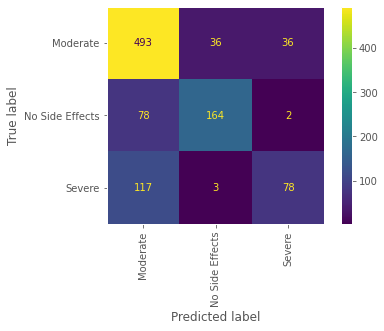

In [25]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_sideEffects_test, preds), display_labels = ['Moderate', 'No Side Effects', 'Severe'])
cm_display.plot(values_format = '.0f', ax=plt.gca(), xticks_rotation='vertical')

plt.grid(False)
plt.show()


In [26]:
y_benefitsReview_train = y_benefitsReview_train.replace({'Considerably Effective':'Considerably', 'Highly Effective':'Considerably',
        'Marginally Effective': 'Marginally', 'Moderately Effective': 'Marginally'})


y_benefitsReview_test = y_benefitsReview_test.replace({'Considerably Effective':'Considerably', 'Highly Effective':'Considerably',
        'Marginally Effective': 'Marginally', 'Moderately Effective': 'Marginally'})



In [27]:
y_benefitsReview_train.value_counts()

effectiveness
Considerably    2188
Marginally       587
Ineffective      231
Name: count, dtype: int64

In [28]:
tokenizer = AutoTokenizer.from_pretrained("medicalai/ClinicalBERT")
model = AutoModel.from_pretrained("medicalai/ClinicalBERT")

In [29]:
benef_train_bert, benef_test_bert = get_emdeddings(model,X_benefitsReview_train, X_benefitsReview_test, tokenizer)

100%|██████████| 63/63 [23:25<00:00, 22.31s/it]


In [30]:
benef_train_nmf, benef_test_nmf = get_nmf(X_benefitsReview_train, X_benefitsReview_test, 10)

In [31]:
train_lda_bert_benef = np.concatenate((benef_train_bert, benef_train_nmf), axis=1)
test_lda_bert_benef = np.concatenate((benef_test_bert, benef_test_nmf), axis=1)

## bert benef

In [32]:
model = CatBoostClassifier(verbose=1000, iterations=1000, random_state=20)
model.fit(benef_train_bert, y_benefitsReview_train)

preds = model.predict(benef_test_bert)
print(classification_report(y_benefitsReview_test, preds))

Learning rate set to 0.083695
0:	learn: 1.0381660	total: 711ms	remaining: 11m 49s
999:	learn: 0.0799953	total: 9m 28s	remaining: 0us
              precision    recall  f1-score   support

Considerably       0.73      0.98      0.84       699
 Ineffective       0.90      0.33      0.49        78
  Marginally       0.55      0.12      0.19       230

    accuracy                           0.73      1007
   macro avg       0.73      0.48      0.51      1007
weighted avg       0.70      0.73      0.66      1007



## bert + nmf benef

In [33]:
model = CatBoostClassifier(verbose=1000, iterations=1000, random_state=20)
model.fit(train_lda_bert_benef, y_benefitsReview_train)

preds = model.predict(test_lda_bert_benef)
print(classification_report(y_benefitsReview_test, preds))

Learning rate set to 0.083695
0:	learn: 1.0414384	total: 601ms	remaining: 9m 59s
999:	learn: 0.0790022	total: 9m 24s	remaining: 0us
              precision    recall  f1-score   support

Considerably       0.73      0.97      0.83       699
 Ineffective       0.90      0.33      0.49        78
  Marginally       0.47      0.10      0.16       230

    accuracy                           0.72      1007
   macro avg       0.70      0.47      0.49      1007
weighted avg       0.68      0.72      0.65      1007



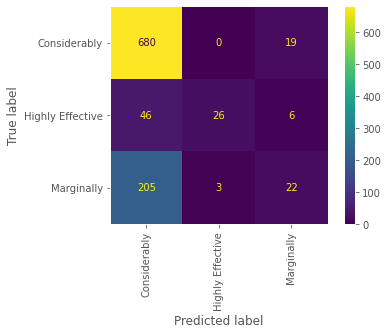

In [34]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_benefitsReview_test, preds), display_labels = ['Considerably', 'Highly Effective', 'Marginally'])
cm_display.plot(values_format = '.0f', ax=plt.gca(), xticks_rotation='vertical')

plt.grid(False)
plt.show()



## Bow side eff


In [35]:
side_train_nmf, side_test_nmf = get_nmf(X_sideEffects_train, X_sideEffects_test)

In [37]:
vectorizer = CountVectorizer(max_df=0.5, min_df=10)
X_train = vectorizer.fit_transform(X_sideEffects_train)

X_test = vectorizer.transform(X_sideEffects_test)

cb = CatBoostClassifier(verbose=1000, random_state=1)
cb.fit(X_train, y_sideEffects_train)

y_pred = cb.predict(X_test)

Learning rate set to 0.083695
0:	learn: 1.0548495	total: 17.3ms	remaining: 17.2s
999:	learn: 0.3763006	total: 21.1s	remaining: 0us


In [38]:
print(classification_report(y_sideEffects_test, y_pred, ),)
print(f1_score(y_sideEffects_test, y_pred, average='micro'),)


                 precision    recall  f1-score   support

       Moderate       0.74      0.87      0.80       565
No Side Effects       0.79      0.74      0.76       244
         Severe       0.72      0.42      0.53       198

       accuracy                           0.75      1007
      macro avg       0.75      0.68      0.70      1007
   weighted avg       0.75      0.75      0.74      1007

0.7507447864945382


## Bow  + nmf side eff

In [39]:
vectorizer = CountVectorizer(max_df=0.5, min_df=10)
X_train = vectorizer.fit_transform(X_sideEffects_train)
X_train = np.concatenate(((X_train).toarray(), side_train_nmf), axis=1)

X_test = vectorizer.transform(X_sideEffects_test)
X_test = np.concatenate((X_test.toarray(), side_test_nmf), axis=1)

cb = CatBoostClassifier(verbose=1000, random_state=1)
cb.fit(X_train, y_sideEffects_train)

y_pred = cb.predict(X_test)

Learning rate set to 0.083695
0:	learn: 1.0505615	total: 46.1ms	remaining: 46.1s
999:	learn: 0.2967110	total: 40.8s	remaining: 0us


In [40]:
print(classification_report(y_sideEffects_test, y_pred))
print(f1_score(y_sideEffects_test, y_pred, average='micro'),)

                 precision    recall  f1-score   support

       Moderate       0.76      0.87      0.81       565
No Side Effects       0.80      0.74      0.77       244
         Severe       0.74      0.48      0.58       198

       accuracy                           0.76      1007
      macro avg       0.76      0.70      0.72      1007
   weighted avg       0.76      0.76      0.76      1007

0.7646474677259185


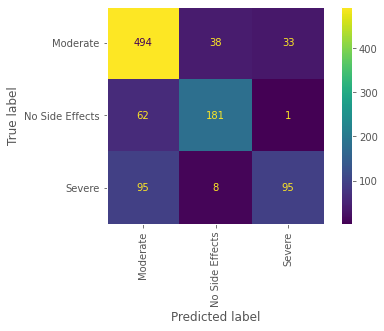

In [41]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_sideEffects_test, y_pred), display_labels = ['Moderate', 'No Side Effects', 'Severe'])
cm_display.plot(values_format = '.0f', ax=plt.gca(), xticks_rotation='vertical')

plt.grid(False)
plt.show()


### Важные слова

In [42]:
nmf = NMF(n_components=10, random_state=42)
vectorizer = CountVectorizer(max_df=0.5, min_df=10)
train = vectorizer.fit_transform(X_sideEffects_train)
test = vectorizer.transform(X_sideEffects_test)
    
nmf.fit(train)

    
    
# Вычисляем веса для каждого слова в каждом отзыве
word_weights = nmf.transform(test)

top_words_indices_per_review = [review_weights.argsort()[-5:][::-1] for review_weights in word_weights]

# Получаем список слов из векторизатора
feature_names = vectorizer.get_feature_names_out()



# indices_of_interest = [141, 144, 145, 147, 153]

for i, (review_indices, label, pred) in enumerate(zip(top_words_indices_per_review, y_sideEffects_test, preds)):
    if label != 'No Side Effects' and pred != 'No Side Effects' and i > 80 and i<120:
        review_words = X_sideEffects_test.iloc[i].split()  # Получаем список слов для текущего отзыва
        top_words = [review_words[idx] for idx in review_indices if idx < len(review_words)]
        print(f"Отзыв: {X_sideEffects_test.iloc[i]}")
        print(f" Важные слова: {', '.join(top_words)} (Класс: {label})")
        print('--------')


Отзыв: experience bowel change although doctor seem think would result drug however experienced constipation
 Важные слова: would, change, drug, bowel, seem (Класс: Moderate)
--------
Отзыв: annoy cough night day ocassionally 10mg cough almost nonexistent 20mg noticeable side effect
 Важные слова: cough, 10mg, night, annoy, 20mg (Класс: Moderate)
--------
Отзыв: severe pain pore also dermatologist tell could wax eyebrow use literally rip top layer skin
 Важные слова: also, dermatologist, use, eyebrow, wax (Класс: Moderate)
--------
Отзыв: hallucination disturb dream effect suppose temporary last couple week still experience month whole experience extremely disturb
 Важные слова: disturb, still, week, last, couple (Класс: Severe)
--------
Отзыв: noticeable side effect unpleasant aftertaste
 Важные слова: side (Класс: Moderate)
--------
Отзыв: bottle water side effect main effect start love look mirror cause see result think kill appetit possible say willing force refuse extra eating mot

## Bow benef

In [43]:
ben_train_nmf, ben_test_nmf = get_nmf(X_benefitsReview_train, X_benefitsReview_test)

In [44]:
vectorizer = CountVectorizer(max_df=0.5, min_df=10)
X_train = vectorizer.fit_transform(X_benefitsReview_train)

X_test = vectorizer.transform(X_benefitsReview_test)

cb = CatBoostClassifier(verbose=1000, random_state=1)
cb.fit(X_train, y_benefitsReview_train)

y_pred = cb.predict(X_test)

Learning rate set to 0.083695
0:	learn: 1.0412486	total: 25.4ms	remaining: 25.3s
999:	learn: 0.3867438	total: 20.1s	remaining: 0us


In [45]:
print(classification_report(y_benefitsReview_test, y_pred, ),)
print(f1_score(y_benefitsReview_test, y_pred, average='micro'),)


              precision    recall  f1-score   support

Considerably       0.76      0.96      0.85       699
 Ineffective       0.72      0.50      0.59        78
  Marginally       0.56      0.15      0.23       230

    accuracy                           0.74      1007
   macro avg       0.68      0.54      0.56      1007
weighted avg       0.71      0.74      0.69      1007

0.7418073485600795


## Bow + nmf benef

In [46]:
vectorizer = CountVectorizer(max_df=0.5, min_df=10)
X_train = vectorizer.fit_transform(X_benefitsReview_train)
X_train = np.concatenate(((X_train).toarray(), ben_train_nmf), axis=1)

X_test = vectorizer.transform(X_benefitsReview_test)
X_test = np.concatenate(((X_test).toarray(), ben_test_nmf), axis=1)

cb = CatBoostClassifier(verbose=1000, random_state=1)
cb.fit(X_train, y_benefitsReview_train)

y_pred = cb.predict(X_test)

Learning rate set to 0.083695
0:	learn: 1.0412726	total: 36.9ms	remaining: 36.8s
999:	learn: 0.3072123	total: 37.2s	remaining: 0us


In [47]:
print(classification_report(y_benefitsReview_test, y_pred, ),)
print(f1_score(y_benefitsReview_test, y_pred, average='micro'),)


              precision    recall  f1-score   support

Considerably       0.75      0.97      0.85       699
 Ineffective       0.73      0.46      0.57        78
  Marginally       0.61      0.15      0.24       230

    accuracy                           0.74      1007
   macro avg       0.70      0.53      0.55      1007
weighted avg       0.72      0.74      0.69      1007

0.7437934458788481


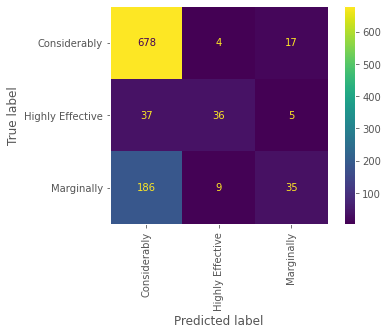

In [49]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_benefitsReview_test, y_pred), display_labels = ['Considerably', 'Highly Effective', 'Marginally'])
cm_display.plot(values_format = '.0f', ax=plt.gca(), xticks_rotation='vertical')

plt.grid(False)
plt.show()


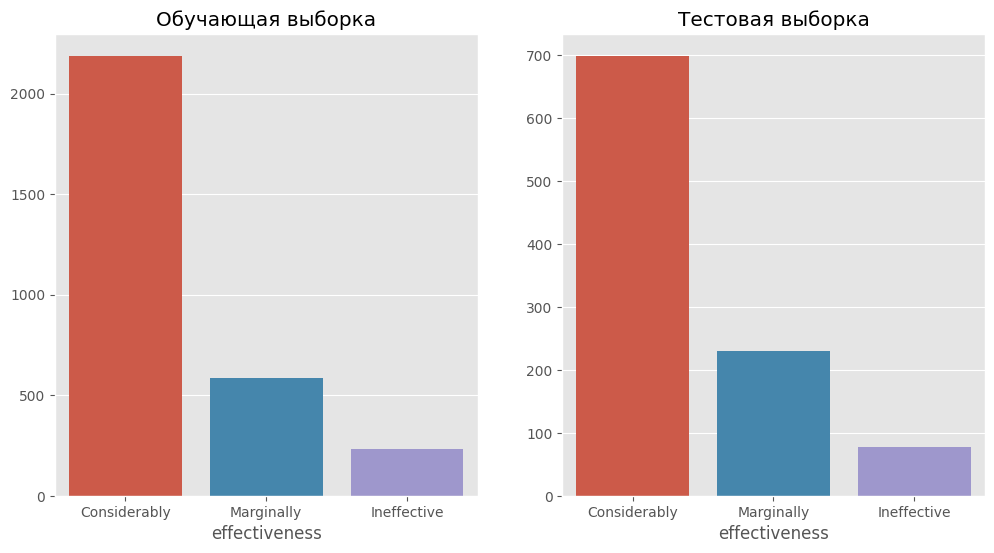

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))


counts_train = y_benefitsReview_train.value_counts()
sns.barplot(x=counts_train.index, y=counts_train.values, ax=axs[0])
axs[0].set_title('Обучающая выборка')

counts = y_benefitsReview_test.value_counts()
sns.barplot(x=counts.index, y=counts.values, ax=axs[1])
axs[1].set_title('Тестовая выборка')

plt.show()



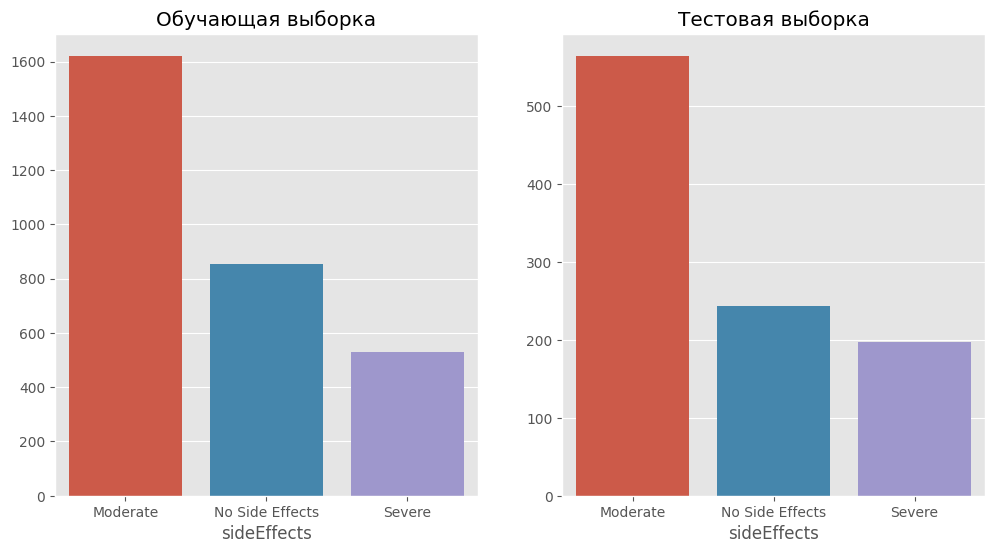

In [78]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))


counts_train = y_sideEffects_train.value_counts()
sns.barplot(x=counts_train.index, y=counts_train.values, ax=axs[0])
axs[0].set_title('Обучающая выборка')

counts = y_sideEffects_test.value_counts()
sns.barplot(x=counts.index, y=counts.values, ax=axs[1])
axs[1].set_title('Тестовая выборка')

plt.show()
